In [1]:
# Install and update essential libraries and tools
!pip install xgboost -U
!pip install librosa -U
# !apt-get --yes install ffmpeg
!pip install hyperopt

  Found existing installation: xgboost 1.1.1
    Uninstalling xgboost-1.1.1:
      Successfully uninstalled xgboost-1.1.1
  Created wheel for resampy: filename=resampy-0.2.2-cp37-none-any.whl size=320724 sha256=4550192bdf3ba4c5c41df158ca02586c5d0268f862fca5dd628cdafad933a52a
  Stored in directory: C:\Users\meetn\AppData\Local\pip\Cache\wheels\fa\c1\56\e0e12c6f7f3d2cdea9712b35136a2d40a7817c6210ec096485
  Created wheel for audioread: filename=audioread-2.1.9-cp37-none-any.whl size=23148 sha256=397cd2b2ab5e118c744fa67542fb0acea3293bfb53e4d84153c33bbe0661d8f7
  Stored in directory: C:\Users\meetn\AppData\Local\pip\Cache\wheels\6d\55\fc\0d9cb2a5a52cc24d86cfcd5db4d40f448a43b9a6046c019fc1
Successfully built resampy audioread
  Found existing installation: joblib 0.13.0
    Uninstalling joblib-0.13.0:
      Successfully uninstalled joblib-0.13.0
  Found existing installation: packaging 19.2
    Uninstalling packaging-19.2:
      Successfully uninstalled packaging-19.2


ERROR: ge 0.0.0 has requirement joblib==0.13.0, but you'll have joblib 1.1.0 which is incompatible.


  Found existing installation: networkx 2.1
    Uninstalling networkx-2.1:
      Successfully uninstalled networkx-2.1


ERROR: ge 0.0.0 has requirement joblib==0.13.0, but you'll have joblib 1.1.0 which is incompatible.
ERROR: ge 0.0.0 has requirement networkx==2.1, but you'll have networkx 2.6.3 which is incompatible.


In [296]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import RFECV,mutual_info_regression
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer

from keras import models
from keras import layers
from keras import regularizers

NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
from xgboost import XGBClassifier
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [58]:
features = pd.read_csv('../data/features.csv')

In [59]:
genre = pd.read_csv('../data/labels.csv')

In [60]:
df = pd.merge(features, genre, on='trackID')

In [61]:
df.head()

,trackID,title,tags,loudness,tempo,time_signature,key,mode,duration,vect_1,...,vect_140,vect_141,vect_142,vect_143,vect_144,vect_145,vect_146,vect_147,vect_148,genre
0,6654,Beside the Yellow Line,"i, the, to, and, a, me, it, not, in, my, is, o...",-8.539,104.341,3.0,7.0,1.0,298.73587,44.462048,...,0.000302,0.000302,0.000315,0.000297,0.000305,0.000266,0.000225,0.130826,1.071914,folk
1,5883,Ooh Na Na,"i, you, to, and, a, me, it, not, in, my, is, y...",-4.326,141.969,3.0,6.0,0.0,236.09424,46.069761,...,0.001855,0.001920,0.001950,0.001937,0.001912,0.001836,0.001740,0.148765,0.882304,soul and reggae
2,3424,Calabria 2008,"i, the, you, to, and, a, me, it, not, in, of, ...",-9.637,126.003,4.0,10.0,0.0,412.94322,40.376622,...,0.001039,0.001116,0.001166,0.001159,0.001110,0.001015,0.000895,0.116206,0.306846,soul and reggae
3,5434,Verbal Abuse (Just an American Band),"i, you, to, and, a, me, it, not, my, is, your,...",-10.969,197.625,4.0,2.0,1.0,64.78322,45.598532,...,0.000284,0.000313,0.000325,0.000324,0.000299,0.000273,0.000236,0.163738,1.247803,punk
4,516,Helen Of Troy,"i, the, to, a, me, it, not, in, is, your, we, ...",-5.369,170.008,4.0,0.0,1.0,191.97342,47.159148,...,0.000927,0.000994,0.001037,0.001051,0.001011,0.000962,0.000898,0.108193,0.366419,dance and electronica


In [62]:
df.columns

Index(['trackID', 'title', 'tags', 'loudness', 'tempo', 'time_signature',
       'key', 'mode', 'duration', 'vect_1',
       ...
       'vect_140', 'vect_141', 'vect_142', 'vect_143', 'vect_144', 'vect_145',
       'vect_146', 'vect_147', 'vect_148', 'genre'],
      dtype='object', length=158)

In [63]:
df.describe()

,trackID,loudness,tempo,time_signature,key,mode,duration,vect_1,vect_2,vect_3,...,vect_139,vect_140,vect_141,vect_142,vect_143,vect_144,vect_145,vect_146,vect_147,vect_148
count,8128.000000,8118.000000,8117.000000,8119.000000,8113.000000,8119.000000,8119.000000,8118.000000,8120.000000,8117.000000,...,8125.000000,8127.000000,8127.000000,8126.000000,8128.000000,8128.000000,8128.000000,8128.000000,8128.000000,8128.000000
mean,4277.619341,-9.528668,125.731032,3.570144,5.239492,0.684813,238.529555,43.676100,3.925979,8.670058,...,0.000717,0.000766,0.000792,0.000816,0.000812,0.000781,0.000746,0.000697,0.194084,5.181209
std,2473.352897,4.402895,34.672811,1.195778,3.591466,0.464619,88.411735,5.656777,48.410113,29.747908,...,0.000652,0.000687,0.000714,0.000723,0.000718,0.000711,0.000686,0.000648,0.086342,41.428973
min,0.000000,-35.726000,0.000000,0.000000,0.000000,0.000000,5.276280,17.606993,-289.862566,-140.558193,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2133.750000,-12.197000,99.836000,3.000000,2.000000,0.000000,186.200360,40.056564,-26.148983,-8.704819,...,0.000279,0.000299,0.000305,0.000319,0.000317,0.000299,0.000292,0.000274,0.129872,0.733115
50%,4276.500000,-8.741500,121.773000,4.000000,5.000000,1.000000,228.048530,44.151439,8.617554,10.006663,...,0.000560,0.000595,0.000610,0.000634,0.000632,0.000598,0.000568,0.000530,0.179694,1.590191
75%,6419.250000,-6.120000,146.929000,4.000000,9.000000,1.000000,275.317100,48.003362,38.102432,27.194705,...,0.000917,0.000987,0.001022,0.001052,0.001052,0.000999,0.000946,0.000872,0.245001,3.743056
max,8555.000000,-0.414000,253.036000,7.000000,11.000000,1.000000,1271.718730,55.564543,150.885303,157.483210,...,0.006545,0.006613,0.006698,0.006682,0.006645,0.006777,0.006770,0.006632,0.767182,3193.622527


In [64]:
df.dtypes

trackID       int64
title        object
tags         object
loudness    float64
tempo       float64
             ...   
vect_145    float64
vect_146    float64
vect_147    float64
vect_148    float64
genre        object
Length: 158, dtype: object

In [65]:
df.columns.to_series().groupby(df.dtypes).groups

{dtype('int64'): Index(['trackID'], dtype='object'),
 dtype('float64'): Index(['loudness', 'tempo', 'time_signature', 'key', 'mode', 'duration',
        'vect_1', 'vect_2', 'vect_3', 'vect_4',
        ...
        'vect_139', 'vect_140', 'vect_141', 'vect_142', 'vect_143', 'vect_144',
        'vect_145', 'vect_146', 'vect_147', 'vect_148'],
       dtype='object', length=154),
 dtype('O'): Index(['title', 'tags', 'genre'], dtype='object')}

## Check for missing values

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8128 entries, 0 to 8127
Columns: 158 entries, trackID to genre
dtypes: float64(154), int64(1), object(3)
memory usage: 9.9+ MB


In [67]:
print(df.isnull().any())

trackID     False
title        True
tags         True
loudness     True
tempo        True
            ...  
vect_145    False
vect_146    False
vect_147    False
vect_148    False
genre       False
Length: 158, dtype: bool


#### There are missing or null values 

In [68]:
df = df.dropna()
df = df.reset_index(drop=True)

## Categorical Variables

In [69]:
list(set(df.dtypes.tolist()))

[dtype('O'), dtype('int64'), dtype('float64')]

In [70]:
df.select_dtypes(include = ['O'])

,title,tags,genre
0,Beside the Yellow Line,"i, the, to, and, a, me, it, not, in, my, is, o...",folk
1,Calabria 2008,"i, the, you, to, and, a, me, it, not, in, of, ...",soul and reggae
2,Verbal Abuse (Just an American Band),"i, you, to, and, a, me, it, not, my, is, your,...",punk
3,Helen Of Troy,"i, the, to, a, me, it, not, in, is, your, we, ...",dance and electronica
4,Only Him Or Me - Original,"i, the, you, to, and, a, me, it, not, in, is, ...",folk
...,...,...,...
7719,Baby Don't Go,"i, the, you, to, and, a, me, it, not, in, is, ...",folk
7720,Silhouette (Album Version),"i, the, you, to, and, a, me, it, not, in, my, ...",folk
7721,I Just Wanna Have Sex With You,"i, the, you, me, it, not, in, my, is, your, do...",punk
7722,Cay's Crays,"i, the, you, and, it, in, my, is, of, your, th...",soul and reggae


### Feature Extraction

There are so many features that were pre-extracted (NO TEMPORAL MEANING) from the 30 or 60 second snippets, and capture timbre, chroma, and mfcc aspects of the audio.

Hence I do not think I need to exract more features, however looking at so many features, we definitely need to find the correlationan and drop the highly correlated ones to decrease the complexity.

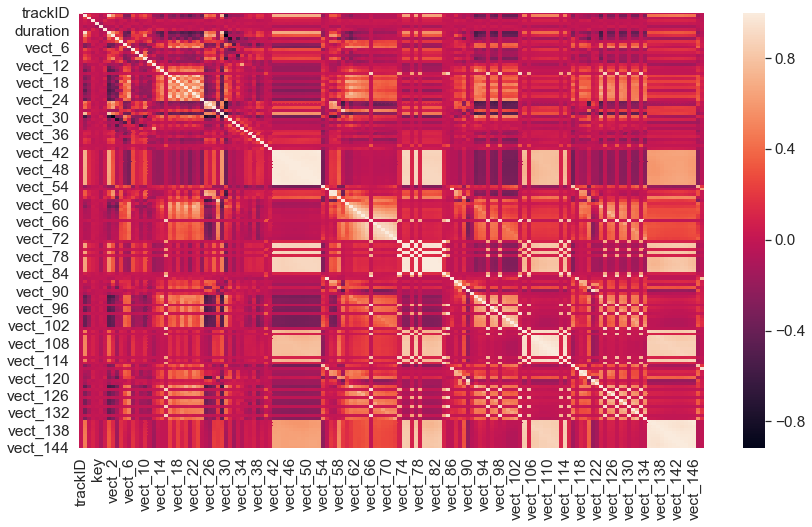

In [71]:
sns.heatmap(df.corr())

In [72]:
corr = df.corr()
sol = (corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
                  .stack()
                  .sort_values(ascending=False))
for index, value in sol.items():
    if (value > 0.75) or (value < -0.75):
        print(index, value)

('vect_73', 'vect_84') 0.9991268962963465
('vect_80', 'vect_81') 0.998855546897461
('vect_79', 'vect_80') 0.9983037766423357
('vect_76', 'vect_78') 0.998067241116164
('vect_81', 'vect_82') 0.9977354006695441
('vect_49', 'vect_50') 0.9976544260514375
('vect_82', 'vect_83') 0.9973544300283418
('vect_47', 'vect_48') 0.9973220873291223
('vect_78', 'vect_84') 0.9972932237369554
('vect_48', 'vect_49') 0.9971538211853926
('vect_73', 'vect_78') 0.9968255397407577
('vect_51', 'vect_52') 0.9964459950750552
('vect_42', 'vect_53') 0.9964417638485503
('vect_73', 'vect_76') 0.9963695789472267
('vect_79', 'vect_81') 0.9963320949864246
('vect_80', 'vect_82') 0.9963317499809037
('vect_46', 'vect_47') 0.9962569355217022
('vect_44', 'vect_45') 0.9961752658857875
('vect_50', 'vect_51') 0.9961720683398743
('vect_74', 'vect_75') 0.9957945865905953
('vect_142', 'vect_143') 0.9955525879046145
('vect_141', 'vect_142') 0.9954469013142118
('vect_52', 'vect_53') 0.9953867881235658
('vect_140', 'vect_141') 0.99523

In [80]:
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
df1 = df.drop(df[to_drop], axis=1)

#Drop the title and tags column for ML. Will include them in Deep Learning
#df1 = df.drop(df[['title', 'tags']], axis=1)
df1.head()



,trackID,title,tags,loudness,tempo,time_signature,key,mode,duration,vect_1,...,vect_125,vect_126,vect_128,vect_129,vect_131,vect_132,vect_134,vect_135,vect_147,genre
0,6654,Beside the Yellow Line,"i, the, to, and, a, me, it, not, in, my, is, o...",-8.539,104.341,3.0,7.0,1.0,298.73587,44.462048,...,0.133488,0.103086,0.101151,0.106527,0.101999,0.115905,0.113459,0.000233,0.130826,folk
1,3424,Calabria 2008,"i, the, you, to, and, a, me, it, not, in, of, ...",-9.637,126.003,4.0,10.0,0.0,412.94322,40.376622,...,0.283598,0.118813,0.114702,0.096954,0.098724,0.088371,0.066879,0.000791,0.116206,soul and reggae
2,5434,Verbal Abuse (Just an American Band),"i, you, to, and, a, me, it, not, my, is, your,...",-10.969,197.625,4.0,2.0,1.0,64.78322,45.598532,...,0.164883,0.135744,0.129829,0.102854,0.094918,0.103986,0.099126,0.000211,0.163738,punk
3,516,Helen Of Troy,"i, the, to, a, me, it, not, in, is, your, we, ...",-5.369,170.008,4.0,0.0,1.0,191.97342,47.159148,...,0.111510,0.094782,0.078143,0.085521,0.078343,0.069124,0.064232,0.000819,0.108193,dance and electronica
4,4906,Only Him Or Me - Original,"i, the, you, to, and, a, me, it, not, in, is, ...",-16.516,142.254,5.0,4.0,1.0,146.75546,36.712606,...,0.281773,0.251474,0.204352,0.212640,0.151589,0.130259,0.154451,0.000113,0.131246,folk


In [81]:
#I am planning to use Deep Learning methods, so I will retain these.
def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a Pandas Series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 

#df1.text = df1[['title', 'tags']]
df1.title = df1.title.apply(remove_stopwords)
df1.tags = df1.tags.apply(remove_stopwords)

In [88]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{"}~\t\n',
               lower=True,
               char_level=False,
               split=' ')
tk.fit_on_texts(df1.title)
df1.title = tk.texts_to_matrix(df1.title, mode='binary')
tk.fit_on_texts(df1.tags)
df1.tags = tk.texts_to_matrix(df1.tags, mode='binary')

In [19]:
print(genre.head())
print(genre.describe())
Genre_counts = genre['genre'].value_counts().rename_axis('Genre').reset_index(name='Count')
Genre_counts.head()

   trackID           genre
0     8424           metal
1     7923            folk
2     2314            folk
3      810  jazz and blues
4      439            folk
           trackID
count  8128.000000
mean   4277.619341
std    2473.352897
min       0.000000
25%    2133.750000
50%    4276.500000
75%    6419.250000
max    8555.000000


,Genre,Count
0,classic pop and rock,1684
1,folk,1665
2,metal,1209
3,soul and reggae,988
4,punk,981


(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

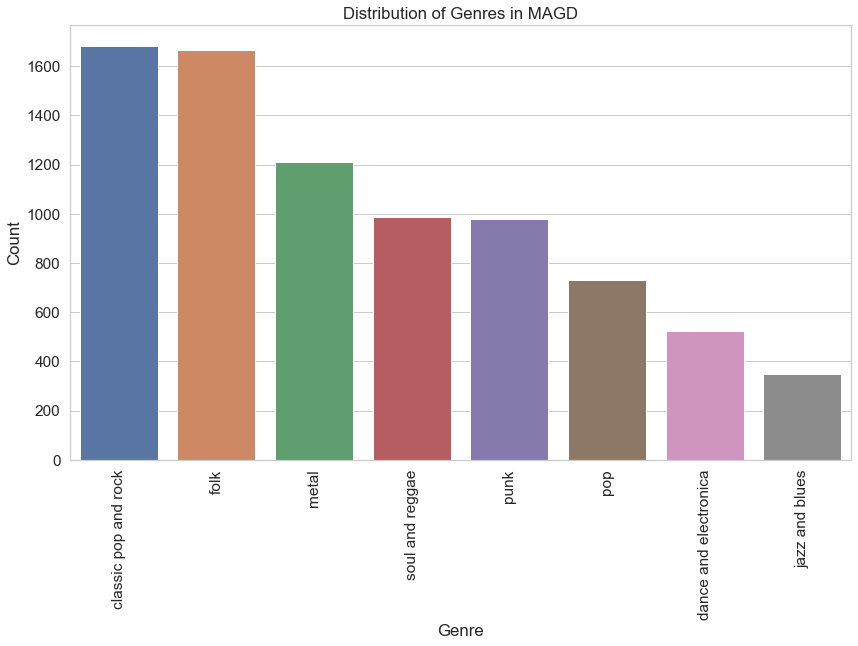

In [20]:
sns.set(rc={'figure.figsize':(14,8)}, font_scale=1.4, style="whitegrid")

ax1 = sns.barplot(x="Genre", y="Count", data=Genre_counts)
ax1.set_title("Distribution of Genres in MAGD")
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

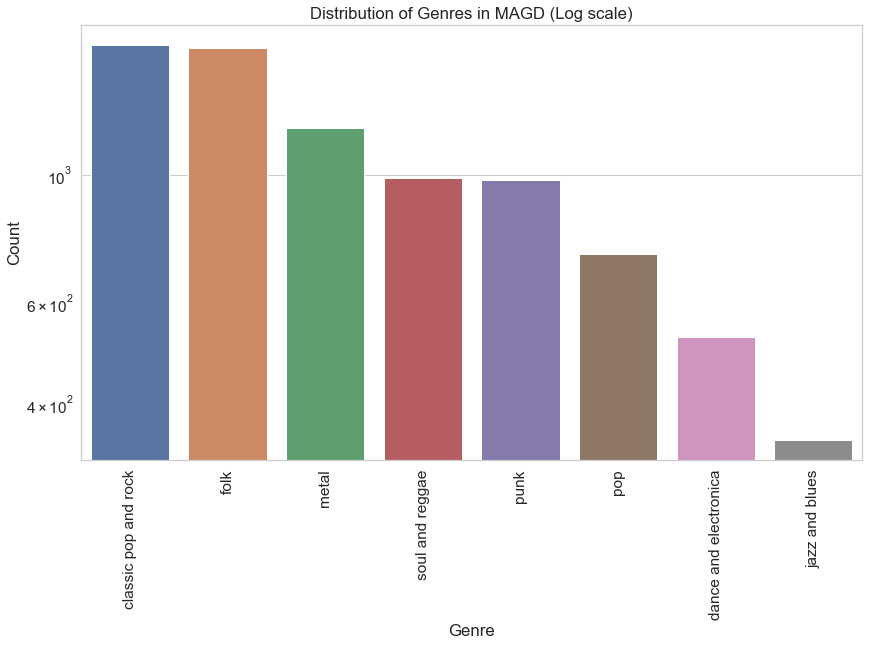

In [21]:
ax2 = sns.barplot(x="Genre", y="Count", data=Genre_counts, log=True,)
ax2.set_title("Distribution of Genres in MAGD (Log scale)")
plt.xticks(rotation=90)

In [89]:
cls_lst = df1[df1.columns.tolist()[-1]]
#print(cls_lst)
convertor = LabelEncoder() 

y = convertor.fit_transform(cls_lst)

In [293]:
integer_mapping = {l: i for i, l in enumerate(convertor.classes_)}
integer_mapping

{'classic pop and rock': 0,
 'dance and electronica': 1,
 'folk': 2,
 'jazz and blues': 3,
 'metal': 4,
 'pop': 5,
 'punk': 6,
 'soul and reggae': 7}

In [90]:
sc = StandardScaler()
X = sc.fit_transform(np.array(df1.iloc[:, :-1], dtype=float))

## Split to train data and test data

Given the small number of training data, I set 80% as training data and 20% as testing data. For hyperameter tuning, given the small dataset, we will use the same train dataset to tune For the split of data, I make sure every class has the same number of data to train and test.

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=df1.genre, random_state=1234)

In [188]:
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=37)

In [217]:
from keras.models import Sequential
NB_START_EPOCHS = 100  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
def trainModel(X_test, y_test, model, epochs, optimizer):
    batch_size = BATCH_SIZE
    model.compile(optimizer = optimizer,
                 loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy']
                 )
    model.fit(X_train_rest, y_train_rest, validation_data=(X_valid, y_valid), epochs = epochs, batch_size = batch_size)
    results = model.evaluate(X_test, y_test)
    print()
    print('Test accuracy: {0:.2f}%'.format(results[1]*100))
    return results

All of the hidden layers are using the RELU activation function and the output layer uses the softmax function. The loss is calculated using the sparse_categorical_crossentropy function.

To address overfitting, I applied various dropout layers.
By applying various Dropout layers, the model still remains overfitted.

In [208]:
def plot_Validation(history):
    print("Validation Accuracy", max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize = (12,6))
    plt.show()

In [209]:
import keras as k
input_shape = X_train_rest[0].shape
model = k.models.Sequential([
                            k.layers.Dense(512, activation='relu', input_shape=input_shape),
                             k.layers.Dropout(0.2),
                             k.layers.Dense(256, activation='relu'),
                             k.layers.Dropout(0.2),
                             k.layers.Dense(128, activation='relu'),
                             k.layers.Dropout(0.2),
                             k.layers.Dense(64, activation='relu'),
                             k.layers.Dropout(0.2),
                             k.layers.Dense(8, activation='softmax')                         
                            ])
print(model.summary())
model_history = trainModel( X_test, y_test, model=model, epochs = 150, optimizer = 'adam')

Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_285 (Dense)            (None, 512)               54272     
_________________________________________________________________
dropout_132 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_286 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_133 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_287 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_134 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_288 (Dense)            (None, 64)              

Epoch 46/150
6255/6255 [==============================] - 0s 27us/step - loss: 0.2749 - accuracy: 0.9068 - val_loss: 1.1515 - val_accuracy: 0.6839
Epoch 47/150
6255/6255 [==============================] - 0s 27us/step - loss: 0.2583 - accuracy: 0.9105 - val_loss: 1.2027 - val_accuracy: 0.6954
Epoch 48/150
6255/6255 [==============================] - 0s 27us/step - loss: 0.2498 - accuracy: 0.9164 - val_loss: 1.2013 - val_accuracy: 0.6882
Epoch 49/150
6255/6255 [==============================] - 0s 28us/step - loss: 0.2447 - accuracy: 0.9185 - val_loss: 1.2488 - val_accuracy: 0.6710
Epoch 50/150
6255/6255 [==============================] - 0s 27us/step - loss: 0.2509 - accuracy: 0.9161 - val_loss: 1.2504 - val_accuracy: 0.6839
Epoch 51/150
6255/6255 [==============================] - 0s 27us/step - loss: 0.2366 - accuracy: 0.9197 - val_loss: 1.2272 - val_accuracy: 0.6853
Epoch 52/150
6255/6255 [==============================] - 0s 26us/step - loss: 0.2164 - accuracy: 0.9282 - val_loss: 1

In [210]:
model_history = trainModel( X_test, y_test, model=model, epochs = 150, optimizer = 'rmsprop')

Train on 6255 samples, validate on 696 samples
Epoch 1/150
6255/6255 [==============================] - 1s 94us/step - loss: 0.1783 - accuracy: 0.9584 - val_loss: 1.8457 - val_accuracy: 0.6710
Epoch 2/150
6255/6255 [==============================] - 0s 28us/step - loss: 0.0616 - accuracy: 0.9794 - val_loss: 1.8150 - val_accuracy: 0.6609
Epoch 3/150
6255/6255 [==============================] - 0s 34us/step - loss: 0.0592 - accuracy: 0.9799 - val_loss: 1.8056 - val_accuracy: 0.6782
Epoch 4/150
6255/6255 [==============================] - 0s 31us/step - loss: 0.0574 - accuracy: 0.9823 - val_loss: 1.9642 - val_accuracy: 0.6739
Epoch 5/150
6255/6255 [==============================] - 0s 30us/step - loss: 0.0605 - accuracy: 0.9800 - val_loss: 1.9071 - val_accuracy: 0.6667
Epoch 6/150
6255/6255 [==============================] - 0s 30us/step - loss: 0.0576 - accuracy: 0.9815 - val_loss: 1.8874 - val_accuracy: 0.6652
Epoch 7/150
6255/6255 [==============================] - 0s 30us/step - loss:

6255/6255 [==============================] - 0s 33us/step - loss: 0.0306 - accuracy: 0.9909 - val_loss: 2.0791 - val_accuracy: 0.6868
Epoch 112/150
6255/6255 [==============================] - 0s 30us/step - loss: 0.0388 - accuracy: 0.9878 - val_loss: 2.0127 - val_accuracy: 0.6839
Epoch 113/150
6255/6255 [==============================] - 0s 34us/step - loss: 0.0363 - accuracy: 0.9878 - val_loss: 2.0494 - val_accuracy: 0.6810
Epoch 114/150
6255/6255 [==============================] - 0s 31us/step - loss: 0.0370 - accuracy: 0.9880 - val_loss: 2.0668 - val_accuracy: 0.7011
Epoch 115/150
6255/6255 [==============================] - 0s 31us/step - loss: 0.0352 - accuracy: 0.9893 - val_loss: 2.0713 - val_accuracy: 0.6825
Epoch 116/150
6255/6255 [==============================] - 0s 32us/step - loss: 0.0334 - accuracy: 0.9902 - val_loss: 2.1301 - val_accuracy: 0.6724
Epoch 117/150
6255/6255 [==============================] - 0s 31us/step - loss: 0.0394 - accuracy: 0.9885 - val_loss: 1.9984 -

In [211]:
model_history = trainModel( X_test, y_test, model=model, epochs = 150, optimizer = 'sgd')

Train on 6255 samples, validate on 696 samples
Epoch 1/150
6255/6255 [==============================] - 1s 94us/step - loss: 0.0288 - accuracy: 0.9914 - val_loss: 2.1186 - val_accuracy: 0.6897
Epoch 2/150
6255/6255 [==============================] - 0s 31us/step - loss: 0.0327 - accuracy: 0.9910 - val_loss: 2.1121 - val_accuracy: 0.6882
Epoch 3/150
6255/6255 [==============================] - 0s 30us/step - loss: 0.0312 - accuracy: 0.9896 - val_loss: 2.1012 - val_accuracy: 0.6882
Epoch 4/150
6255/6255 [==============================] - 0s 30us/step - loss: 0.0244 - accuracy: 0.9915 - val_loss: 2.0952 - val_accuracy: 0.6868
Epoch 5/150
6255/6255 [==============================] - 0s 30us/step - loss: 0.0241 - accuracy: 0.9930 - val_loss: 2.0934 - val_accuracy: 0.6868
Epoch 6/150
6255/6255 [==============================] - 0s 32us/step - loss: 0.0236 - accuracy: 0.9917 - val_loss: 2.0905 - val_accuracy: 0.6839
Epoch 7/150
6255/6255 [==============================] - 0s 29us/step - loss:

Epoch 112/150
6255/6255 [==============================] - 0s 23us/step - loss: 0.0149 - accuracy: 0.9965 - val_loss: 2.0512 - val_accuracy: 0.6911
Epoch 113/150
6255/6255 [==============================] - 0s 21us/step - loss: 0.0127 - accuracy: 0.9968 - val_loss: 2.0517 - val_accuracy: 0.6911
Epoch 114/150
6255/6255 [==============================] - 0s 25us/step - loss: 0.0125 - accuracy: 0.9966 - val_loss: 2.0511 - val_accuracy: 0.6911
Epoch 115/150
6255/6255 [==============================] - 0s 28us/step - loss: 0.0132 - accuracy: 0.9968 - val_loss: 2.0511 - val_accuracy: 0.6897
Epoch 116/150
6255/6255 [==============================] - 0s 30us/step - loss: 0.0132 - accuracy: 0.9960 - val_loss: 2.0522 - val_accuracy: 0.6897
Epoch 117/150
6255/6255 [==============================] - 0s 30us/step - loss: 0.0172 - accuracy: 0.9944 - val_loss: 2.0518 - val_accuracy: 0.6911
Epoch 118/150
6255/6255 [==============================] - ETA: 0s - loss: 0.0089 - accuracy: 0.99 - 0s 28us/ste

To address overfitting, we can apply weight regularization to the model
L1 regularization will add a cost with regards to the absolute value of the parameters. It will result in some of the weights to be equal to zero.
L2 regularization will add a cost with regards to the squared value of the parameters. This results in smaller weights.

For the CNN model, I used the Adam optimizer for training the model. The epoch that was chosen for the training model is 100.

Dropout is used to prevent overfitting.
We chose the Adam optimizer because it gave us the best results after evaluating other optimizers.
The model accuracy can be increased by further increasing the epochs, or by adding more regularization etc but after a certain period, we may achieve a threshold, so the value should be determined accordingly.

In [244]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    model.compile(optimizer='adam'
                  , loss='sparse_categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    return history

In [224]:
def eval_metric(model, history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]
    e = range(1, NB_START_EPOCHS + 1)
    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name + ' for ' + model.name)
    plt.legend()
    plt.show()

In [225]:
def optimal_epoch(model_hist):
    '''
    Function to return the epoch number where the validation loss is
    at its minimum
    
    Parameters:
        model_hist : training history of model
    Output:
        epoch number with minimum validation loss
    '''
    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    print("Minimum validation loss reached in epoch {}".format(min_epoch))
    return min_epoch

In [198]:
def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    print()
    print('Test accuracy: {0:.2f}%'.format(results[1]*100))
    return results

Minimum validation loss reached in epoch 7


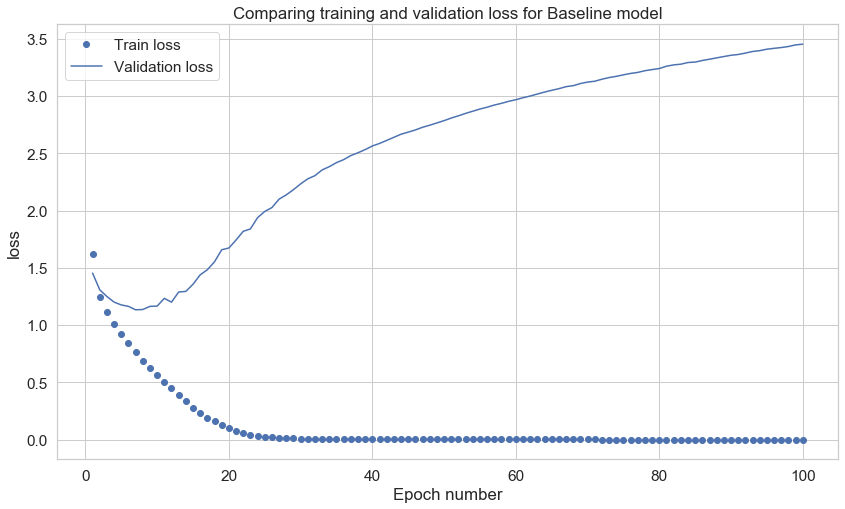

773/773 [==============================] - 0s 37us/step

Test accuracy: 63.00%


In [226]:
base_model = k.models.Sequential([
            k.layers.Dense(512, activation='relu', input_shape=input_shape),
             k.layers.Dense(256, activation='relu'),         
             k.layers.Dense(128, activation='relu'),       
             k.layers.Dense(64, activation='relu'),          
             k.layers.Dense(8, activation='softmax')                         
            ])                   
base_model.name = 'Baseline model'
base_history = deep_model(base_model, X_train, y_train, X_test, y_test)
base_min = optimal_epoch(base_history)
eval_metric(base_model, base_history, 'loss')
base_results = test_model(base_model, X_train, y_train, X_test, y_test, base_min)

Minimum validation loss reached in epoch 66


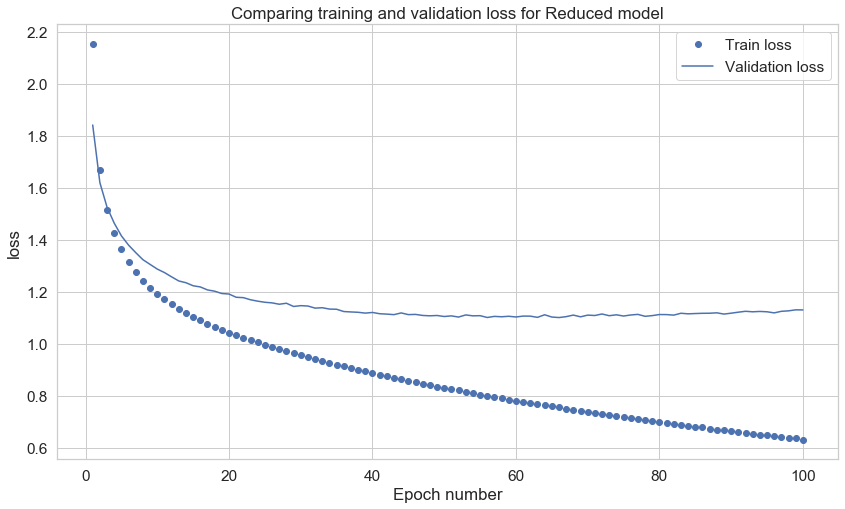

773/773 [==============================] - 0s 21us/step

Test accuracy: 58.86%


In [228]:
reduced_model = k.models.Sequential([
            k.layers.Dense(64, activation='relu', input_shape=input_shape),    
             k.layers.Dense(8, activation='softmax')                         
            ])  
reduced_model.name = 'Reduced model'
reduced_history = deep_model(reduced_model, X_train_rest, y_train_rest, X_valid, y_valid)
reduced_min = optimal_epoch(reduced_history)
eval_metric(reduced_model, reduced_history, 'loss')
reduced_results = test_model(reduced_model, X_train, y_train, X_test, y_test, reduced_min)

Minimum validation loss reached in epoch 30


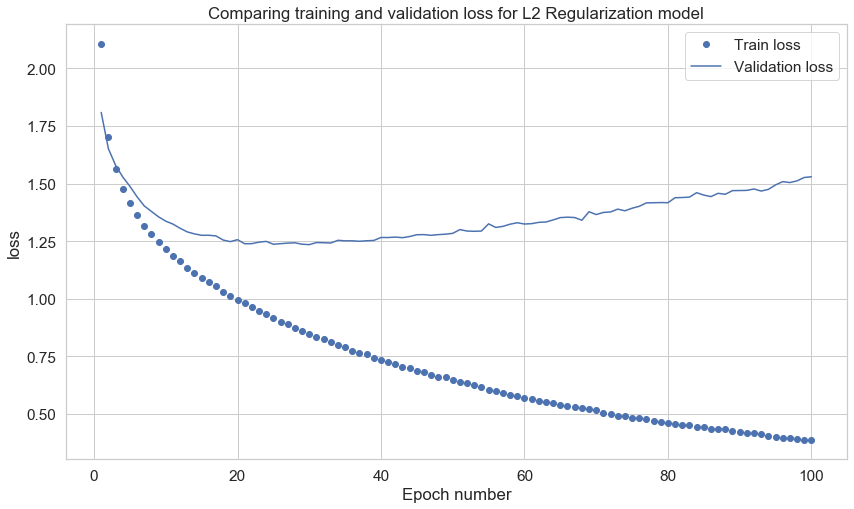

773/773 [==============================] - 0s 22us/step

Test accuracy: 62.23%


In [229]:
reg_model = k.models.Sequential([
    k.layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=input_shape),
                             k.layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
                             k.layers.Dense(8, activation='softmax')                         
                            ])
reg_model.name = 'L2 Regularization model'
reg_history = deep_model(reg_model, X_train_rest, y_train_rest, X_valid, y_valid)
reg_min = optimal_epoch(reg_history)
eval_metric(reg_model, reg_history, 'loss')
reg_results = test_model(reg_model, X_train, y_train, X_test, y_test, reg_min)

Minimum validation loss reached in epoch 28


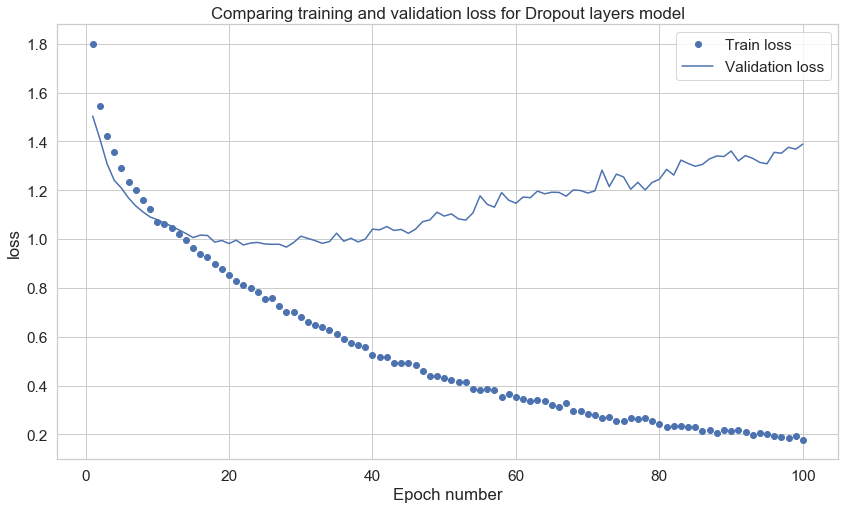

773/773 [==============================] - 0s 51us/step

Test accuracy: 68.18%


In [246]:
drop_model = k.models.Sequential([
                            k.layers.Dense(512, activation='relu', input_shape=input_shape),
                             k.layers.Dropout(0.3),
                             k.layers.Dense(256, activation='relu'),
                             k.layers.Dropout(0.3),
                             k.layers.Dense(128, activation='relu'),
                             k.layers.Dropout(0.2),
                             k.layers.Dense(64, activation='relu'),
                             k.layers.Dropout(0.2),
                             k.layers.Dense(8, activation='softmax')                         
                            ])
drop_model.name = 'Dropout layers model'
drop_history = deep_model(drop_model, X_train_rest, y_train_rest, X_valid, y_valid)
drop_min = optimal_epoch(drop_history)
eval_metric(drop_model, drop_history, 'loss')
drop_results = test_model(drop_model, X_train, y_train, X_test, y_test, drop_min)

In [232]:
print('base_results')
base_results = test_model(base_model, X_train, y_train, X_test, y_test, base_min)
print('reduced_results')
reduced_results = test_model(reduced_model, X_train, y_train, X_test, y_test, reduced_min)
print('reg_results')
reg_results = test_model(reg_model, X_train, y_train, X_test, y_test, reg_min)
print('drop_results')
drop_results = test_model(drop_model, X_train, y_train, X_test, y_test, drop_min)

base_results
773/773 [==============================] - 0s 35us/step

Test accuracy: 63.13%
reduced_results
773/773 [==============================] - 0s 30us/step

Test accuracy: 58.60%
reg_results
773/773 [==============================] - 0s 20us/step

Test accuracy: 61.58%
drop_results
773/773 [==============================] - 0s 40us/step

Test accuracy: 66.62%


### Using recursive feature elimination(RFECV) in XGBClassifier
I found out that these features can also be dropped

In [254]:
features_drop_array = ['trackID', 'time_signature', 'key', 'mode', 'vect_12', 'vect_22',
       'vect_25', 'vect_26', 'vect_33', 'vect_40', 'vect_43', 'vect_49',
       'vect_51', 'vect_52', 'vect_56', 'vect_64', 'vect_66', 'vect_69',
       'vect_70', 'vect_71', 'vect_80', 'vect_82', 'vect_83', 'vect_84',
       'vect_87', 'vect_89', 'vect_91', 'vect_97', 'vect_98', 'vect_100',
       'vect_111', 'vect_113', 'vect_115', 'vect_116', 'vect_119', 'vect_123',
       'vect_127', 'vect_130', 'vect_144', 'vect_145']
rem_feats_to_drop = list(set(features_drop_array).difference(to_drop))

In [255]:
df2 = df1.drop(df1[rem_feats_to_drop], axis=1)

In [256]:
df2.head()

,title,tags,loudness,tempo,duration,vect_1,vect_2,vect_3,vect_4,vect_5,...,vect_125,vect_126,vect_128,vect_129,vect_131,vect_132,vect_134,vect_135,vect_147,genre
0,0.0,0.0,-8.539,104.341,298.73587,44.462048,-13.499814,26.257028,-2.794023,10.635086,...,0.133488,0.103086,0.101151,0.106527,0.101999,0.115905,0.113459,0.000233,0.130826,folk
1,0.0,0.0,-9.637,126.003,412.94322,40.376622,27.546188,-24.231226,49.840873,-2.128631,...,0.283598,0.118813,0.114702,0.096954,0.098724,0.088371,0.066879,0.000791,0.116206,soul and reggae
2,0.0,0.0,-10.969,197.625,64.78322,45.598532,10.249509,52.666606,1.962486,-28.990688,...,0.164883,0.135744,0.129829,0.102854,0.094918,0.103986,0.099126,0.000211,0.163738,punk
3,0.0,0.0,-5.369,170.008,191.97342,47.159148,-52.070941,18.232822,31.694016,-16.331575,...,0.111510,0.094782,0.078143,0.085521,0.078343,0.069124,0.064232,0.000819,0.108193,dance and electronica
4,0.0,0.0,-16.516,142.254,146.75546,36.712606,-1.896533,3.454569,-9.656709,-52.225433,...,0.281773,0.251474,0.204352,0.212640,0.151589,0.130259,0.154451,0.000113,0.131246,folk


In [257]:
sc = StandardScaler()
X_new = sc.fit_transform(np.array(df2.iloc[:, :-1], dtype=float))

In [258]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y, test_size=0.1, stratify=df1.genre, random_state=1000)
X_train_rest_new, X_valid_new, y_train_rest_new, y_valid_new = train_test_split(X_train_new, y_train_new, test_size=0.1, random_state=1001)

In [264]:
X_train_rest_new.shape, y_train_rest_new.shape, X_valid_new.shape, y_valid_new.shape

((6255, 81), (6255,), (696, 81), (696,))

Early stopping rules provide guidance as to how many iterations can be run before the model begins to overfit.

In [309]:
filepath = "dropout_v1.h5"
earlyStopping = EarlyStopping(monitor='val_loss', verbose=0, mode='min', patience = 4)
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', mode='min')

input_shape_new = X_train_rest_new[0].shape
drop_model_new1 = k.models.Sequential([
                            k.layers.Dense(512, activation='relu', input_shape=input_shape_new),
                             k.layers.Dropout(0.3),
                             k.layers.Dense(256, activation='relu'),
                             k.layers.Dropout(0.3),
                             k.layers.Dense(128, activation='relu'),
                             k.layers.Dropout(0.2),
                             k.layers.Dense(64, activation='relu'),
                             k.layers.Dropout(0.2),
                             k.layers.Dense(8, activation='softmax')                         
                            ])
#drop_model_new1.name = 'Dropout layers model_new1'
#drop_history_new1 = deep_model(drop_model_new1, X_train_rest_new, y_train_rest_new, X_valid_new, y_valid_new)
#drop_min_new1 = optimal_epoch(drop_history_new1)
#eval_metric(drop_model_new1, drop_history_new1, 'loss')
#drop_results_new1 = test_model(drop_model_new1, X_train_new, y_train_new, X_test_new, y_test_new, drop_min_new)
drop_model_new1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_drop_model_new1 = drop_model_new1.fit(X_train_rest_new, y_train_rest_new, validation_data=(X_valid_new, y_valid_new), epochs=100, verbose=0, callbacks=[earlyStopping, mcp_save])
# evaluate the model
_, train_acc = drop_model_new1.evaluate(X_train_rest_new, y_train_rest_new, verbose=0)
_, test_acc = drop_model_new1.evaluate(X_test_new, y_test_new, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.878, Test: 0.649


Minimum validation loss reached in epoch 31


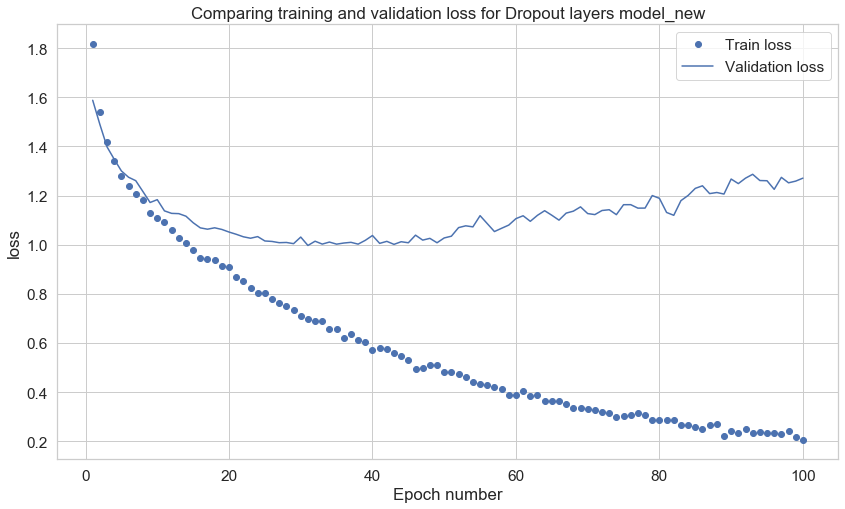

773/773 [==============================] - 0s 27us/step

Test accuracy: 70.76%


In [273]:
input_shape_new = X_train_rest_new[0].shape
drop_model_new = k.models.Sequential([
                            k.layers.Dense(512, activation='relu', input_shape=input_shape_new),
                             k.layers.Dropout(0.3),
                             k.layers.Dense(256, activation='relu'),
                             k.layers.Dropout(0.3),
                             k.layers.Dense(128, activation='relu'),
                             k.layers.Dropout(0.2),
                             k.layers.Dense(64, activation='relu'),
                             k.layers.Dropout(0.2),
                             k.layers.Dense(8, activation='softmax')                         
                            ])
drop_model_new.name = 'Dropout layers model_new'
drop_history_new = deep_model(drop_model_new, X_train_rest_new, y_train_rest_new, X_valid_new, y_valid_new)
drop_min_new = optimal_epoch(drop_history_new)
eval_metric(drop_model_new, drop_history_new, 'loss')
drop_results_new = test_model(drop_model_new, X_train_new, y_train_new, X_test_new, y_test_new, drop_min_new)

In [274]:
# serialize model to JSON
model_json = drop_model_new.to_json()
with open("../data/drop_model_new.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
drop_model_new.save_weights("../data/drop_model_new.h5")
print("Saved model to disk")

Saved model to disk


In [56]:
# load json and create model
json_file = open('../data/drop_model_new.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("../data/drop_model_new.h5")
print("Loaded model from disk")

Loaded model from disk


In [126]:
def preprocessing(df_test: object) -> object:
    df_test = df_test.dropna()
    df_test = df_test.reset_index(drop=True)

    #features to drop based on high correlation
    corr_to_drop = ['vect_43', 'vect_44', 'vect_45', 'vect_46', 'vect_47', 'vect_48', 'vect_49', 'vect_50', 'vect_51',
    'vect_52', 'vect_53', 'vect_57', 'vect_75', 'vect_76', 'vect_77', 'vect_78', 'vect_79', 'vect_80', 'vect_81', 
    'vect_82', 'vect_83', 'vect_84', 'vect_86', 'vect_95', 'vect_98', 'vect_103', 'vect_107', 'vect_108', 'vect_109',
    'vect_110', 'vect_111', 'vect_112', 'vect_113', 'vect_114', 'vect_115', 'vect_121', 'vect_124', 'vect_127', 
    'vect_130', 'vect_133', 'vect_136', 'vect_137', 'vect_138', 'vect_139', 'vect_140', 'vect_141', 'vect_142', 'vect_143', 
    'vect_144', 'vect_145', 'vect_146', 'vect_148']
    
    df_test = df_test.drop(df_test[corr_to_drop], axis=1)
    
    #features to drop based on recursive feature elimination on xgboost model
    features_drop_array = ['trackID', 'time_signature', 'key', 'mode', 'vect_12', 'vect_22',
       'vect_25', 'vect_26', 'vect_33', 'vect_40', 'vect_43', 'vect_49',
       'vect_51', 'vect_52', 'vect_56', 'vect_64', 'vect_66', 'vect_69',
       'vect_70', 'vect_71', 'vect_80', 'vect_82', 'vect_83', 'vect_84',
       'vect_87', 'vect_89', 'vect_91', 'vect_97', 'vect_98', 'vect_100',
       'vect_111', 'vect_113', 'vect_115', 'vect_116', 'vect_119', 'vect_123',
       'vect_127', 'vect_130', 'vect_144', 'vect_145']

    # final features to drop
    rem_feats_to_drop = list(set(features_drop_array).difference(corr_to_drop))
    df_test = df_test.drop(df_test[rem_feats_to_drop], axis=1)
    
    return df_test

In [127]:
df_test.columns

Index(['trackID', 'title', 'tags', 'loudness', 'tempo', 'time_signature',
       'key', 'mode', 'duration', 'vect_1',
       ...
       'vect_139', 'vect_140', 'vect_141', 'vect_142', 'vect_143', 'vect_144',
       'vect_145', 'vect_146', 'vect_147', 'vect_148'],
      dtype='object', length=157)

In [128]:
df_test = pd.read_csv('../data/test.csv')
df_test1 = preprocessing(df_test)

In [129]:
df_test1.head()

,title,tags,loudness,tempo,duration,vect_1,vect_2,vect_3,vect_4,vect_5,...,vect_122,vect_125,vect_126,vect_128,vect_129,vect_131,vect_132,vect_134,vect_135,vect_147
0,You Get What You Give,"i, the, you, to, and, a, me, it, not, in, is, ...",-5.672,113.941,300.82567,49.707499,38.764963,33.624619,-0.503471,13.280484,...,1.559438,0.259174,0.204383,0.133214,0.096231,0.109911,0.104719,0.102839,0.000445,0.210010
1,Greedee,"i, the, you, to, and, a, me, it, not, in, my, ...",-7.931,102.062,259.60444,46.829729,34.486951,5.831063,2.514340,-29.273407,...,2.843339,0.196508,0.138881,0.114244,0.093184,0.078491,0.076447,0.066383,0.000318,0.124080
2,Wonderful World,"i, the, you, to, and, a, me, not, is, your, th...",-16.714,85.513,128.36526,36.930941,-155.145954,59.861600,7.918767,-66.722804,...,3.086394,0.254248,0.199891,0.153652,0.125251,0.117784,0.110190,0.129866,0.000314,0.342681
3,Michoacan,"i, the, to, and, a, me, not, in, my, is, of, t...",-13.346,124.447,180.37506,39.044785,-9.476363,22.046001,6.148981,-31.097917,...,2.796537,0.262958,0.183968,0.160979,0.142937,0.146429,0.110197,0.087291,0.000221,0.268061
4,HUSTLER,"i, the, you, to, and, a, me, it, not, in, my, ...",-9.365,127.018,483.26485,41.512947,37.982154,-51.929321,26.663140,5.278338,...,2.754977,0.226147,0.202188,0.148127,0.138720,0.133571,0.125081,0.099656,0.002146,0.214922


In [57]:
loaded_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(X_test_new, y_test_new, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

NameError: name 'X_test_new' is not defined

In [280]:
y_pred_new = loaded_model.predict(X_test_new)
y_pred_new

array([[7.4339912e-09, 1.7673122e-08, 7.3929210e-11, ..., 3.1653286e-10,
        6.4620055e-04, 4.0414915e-12],
       [7.8887647e-01, 9.5327359e-06, 2.0859653e-01, ..., 3.6334197e-04,
        5.9451675e-05, 1.7017708e-03],
       [9.2500642e-07, 2.6245883e-07, 2.1229695e-08, ..., 3.6347465e-08,
        8.8297790e-03, 1.0482889e-09],
       ...,
       [8.7647786e-06, 3.2745056e-06, 5.4853917e-06, ..., 5.5072367e-05,
        9.9986207e-01, 2.9993153e-06],
       [2.6286981e-04, 4.4938392e-06, 3.1536620e-04, ..., 1.3193593e-06,
        4.3160463e-07, 6.7372916e-05],
       [3.8742590e-01, 2.3281336e-04, 6.0470790e-01, ..., 5.1548732e-03,
        1.4283932e-04, 1.5412911e-03]], dtype=float32)

In [305]:
classes = np.argmax(y_pred_new, axis = 1)
print(classes)

[4 0 4 6 0 2 7 7 0 7 5 2 0 4 6 4 2 2 4 2 4 0 0 0 7 7 2 2 2 0 3 0 5 5 6 4 6
 1 2 5 2 6 0 7 4 0 0 0 4 3 6 5 5 5 0 4 0 4 0 6 7 2 2 0 1 7 4 7 5 0 5 7 2 4
 0 2 3 0 4 2 7 0 0 0 1 3 0 6 2 4 4 2 0 0 7 0 4 6 7 5 0 7 0 0 6 7 5 0 5 7 7
 5 2 5 2 2 2 0 2 3 2 0 0 2 2 0 0 6 1 1 7 6 7 6 6 2 2 2 2 7 2 6 2 4 4 5 4 2
 7 0 2 6 2 7 4 3 2 6 1 6 5 2 4 0 0 6 1 4 2 2 7 7 5 1 2 2 5 0 2 2 1 4 2 0 7
 2 2 1 4 7 2 7 4 3 2 0 2 0 7 0 0 6 2 2 4 5 0 2 6 4 0 2 7 0 2 1 7 5 4 4 7 3
 4 4 4 0 7 2 4 4 0 2 5 4 0 7 7 2 0 2 7 4 0 0 4 6 7 7 6 0 7 0 5 0 0 6 7 4 2
 4 5 4 2 0 1 0 6 0 2 4 2 2 4 6 6 0 2 4 6 5 7 6 2 0 2 2 2 0 0 2 0 2 2 0 0 4
 4 2 2 0 3 0 7 0 0 5 2 6 0 0 1 7 1 0 5 6 2 2 7 4 6 7 7 5 6 6 5 4 0 2 6 4 2
 0 6 6 0 7 0 2 2 4 0 2 2 4 4 1 3 5 3 6 2 4 7 2 0 7 5 0 0 6 7 4 0 6 2 6 7 2
 0 7 0 6 2 0 5 1 4 2 1 7 7 2 0 3 6 6 0 4 6 6 0 0 2 4 4 1 2 0 2 0 7 4 2 7 6
 2 2 2 2 5 0 6 2 5 0 6 7 3 4 4 5 0 4 4 2 6 2 0 2 7 2 0 4 5 0 0 0 0 1 4 1 2
 7 3 4 2 6 4 6 6 4 0 1 7 4 0 0 7 2 6 4 2 4 2 0 1 4 7 6 7 2 7 4 0 2 4 2 2 1
 2 4 4 0 4 0 6 4 4 2 7 4 

In [19]:
import json
labels_mapping = {'classic pop and rock': 0,
 'dance and electronica': 1,
 'folk': 2,
 'jazz and blues': 3,
 'metal': 4,
 'pop': 5,
 'punk': 6,
 'soul and reggae': 7}
with open('labels_mapping.json', 'w') as fp:
    json.dump(labels_mapping, fp)

In [21]:
with open('labels_mapping.json') as json_file:
    labels_json_file = json.load(json_file)
print(labels_json_file)

{'classic pop and rock': 0, 'dance and electronica': 1, 'folk': 2, 'jazz and blues': 3, 'metal': 4, 'pop': 5, 'punk': 6, 'soul and reggae': 7}


In [38]:
import pickle
pickle.dump(sc, open('sc.pkl','wb'))

In [40]:
with open('sc.pkl', 'rb') as f:
    sc = pickle.load(f)

In [44]:
arr = []
for key, value in labels_json_file.items():
    for i in classes:
        if value == i:
            arr.append(key)
arr

['classic pop and rock', 'metal', 'metal', 'punk']

In [77]:
p = dict(zip(labels_json_file.values(),labels_json_file.keys()))
labels = [p[k] for k in classes]
labels

['metal', 'classic pop and rock', 'metal', 'punk']

In [74]:
from datetime import datetime
current = datetime.now()

In [79]:
np.repeat(current, len(labels))

array([datetime.datetime(2022, 1, 18, 3, 0, 33, 596414),
       datetime.datetime(2022, 1, 18, 3, 0, 33, 596414),
       datetime.datetime(2022, 1, 18, 3, 0, 33, 596414),
       datetime.datetime(2022, 1, 18, 3, 0, 33, 596414)], dtype=object)

In [83]:
dfT = df_test[0:4]

In [84]:
data = {'trackID': dfT['trackID'], 'title': dfT['title'], 'genre': labels, 'created': np.repeat(current, len(labels))}

In [86]:
dfT['genre'] = labels

/home/Manisha/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [88]:
dfT['created'] = current

/home/Manisha/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [90]:
dfT.drop(dfT.columns.difference(['trackID','title', 'genre', 'created']), 1, inplace=True)

/home/Manisha/.local/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [91]:
dfT

,trackID,title,genre,created
0,6732,You Get What You Give,metal,2022-01-18 03:00:33.596414
1,5415,Greedee,classic pop and rock,2022-01-18 03:00:33.596414
2,7757,Wonderful World,metal,2022-01-18 03:00:33.596414
3,1854,Michoacan,punk,2022-01-18 03:00:33.596414
